# Understanding Trust Region Policy Optimization (TRPO): A Complete Guide

## Table of Contents

- [Introduction](#introduction)
- [What is TRPO?](#what-is-trpo)
  - [Why Trust Regions for Policy Optimization?](#why-trust-regions)
- [Where and How TRPO is Used](#where-and-how-trpo-is-used)
- [Mathematical Foundation of TRPO](#mathematical-foundation-of-trpo)
  - [Policy Gradient Recap](#policy-gradient-recap)
  - [The Problem with Vanilla Policy Gradients](#the-problem-with-vanilla-policy-gradients)
  - [The Surrogate Objective Function](#the-surrogate-objective-function)
  - [The Trust Region Constraint (KL Divergence)](#the-trust-region-constraint-kl-divergence)
  - [Approximation and the Optimization Problem](#approximation-and-the-optimization-problem)
  - [Fisher Information Matrix (FIM)](#fisher-information-matrix-fim)
  - [Solving the Constrained Problem: Conjugate Gradient](#solving-the-constrained-problem-conjugate-gradient)
  - [Ensuring the Constraint: Backtracking Line Search](#ensuring-the-constraint-backtracking-line-search)
  - [Advantage Estimation: GAE](#advantage-estimation-gae)
- [Step-by-Step Explanation of TRPO](#step-by-step-explanation-of-trpo)
- [Key Components of TRPO](#key-components-of-trpo)
  - [Policy Network (Actor)](#policy-network-actor)
  - [Value Network (Critic)](#value-network-critic)
  - [Rollout Collection (On-Policy)](#rollout-collection-on-policy)
  - [Advantage Estimation (GAE)](#advantage-estimation-gae)
  - [Policy Gradient Calculation](#policy-gradient-calculation)
  - [Fisher-Vector Product (FVP)](#fisher-vector-product-fvp)
  - [Conjugate Gradient (CG) Algorithm](#conjugate-gradient-cg-algorithm)
  - [Backtracking Line Search](#backtracking-line-search)
  - [Value Function Update](#value-function-update)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Custom Grid World](#practical-example-custom-grid-world)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Custom Environment](#creating-the-custom-environment)
- [Implementing the TRPO Algorithm](#implementing-the-trpo-algorithm)
  - [Defining the Policy Network (Actor)](#defining-the-policy-network-actor)
  - [Defining the Value Network (Critic)](#defining-the-value-network-critic)
  - [Calculating KL Divergence](#calculating-kl-divergence)
  - [Calculating Generalized Advantage Estimation (GAE)](#calculating-generalized-advantage-estimation-gae)
  - [Computing the Fisher-Vector Product (FVP)](#computing-the-fisher-vector-product-fvp)
  - [Implementing the Conjugate Gradient Algorithm](#implementing-the-conjugate-gradient-algorithm)
  - [Implementing the Backtracking Line Search](#implementing-the-backtracking-line-search)
  - [The TRPO Update Step](#the-trpo-update-step)
  - [Value Function Optimization Step](#value-function-optimization-step)
- [Running the TRPO Algorithm](#running-the-trpo-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policy (Optional Visualization)](#analyzing-the-learned-policy-optional-visualization)
- [Common Challenges and Solutions in TRPO](#common-challenges-and-solutions-in-trpo)
- [Conclusion](#conclusion)

## Introduction

Trust Region Policy Optimization (TRPO) is an advanced policy gradient method in reinforcement learning. It addresses a key instability issue found in simpler methods like REINFORCE: large, poorly chosen policy updates can drastically reduce performance, sometimes leading to catastrophic collapse. TRPO aims to guarantee (or make highly likely) monotonic improvement in policy performance by constraining the size of policy updates within a 'trust region' defined by the Kullback-Leibler (KL) divergence.

## What is TRPO?

TRPO is an iterative algorithm that seeks to improve a stochastic policy $\pi(a|s; \theta)$ parameterized by $\theta$. At each iteration, it solves a constrained optimization problem:

1.  **Maximize** an objective function (the *surrogate advantage*) that approximates the expected improvement in performance.
2.  **Subject to** a constraint that the change in the policy (measured by the average KL divergence between the old policy $\pi_{\theta_{old}}$ and the new policy $\pi_{\theta}$) is less than a small constant $\delta$.

$$ \max_{\theta} \quad \mathbb{E}_{s \sim \rho_{\theta_{old}}, a \sim \pi_{	heta_{old}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)} A^{\pi_{\theta_{old}}}(s,a) \right] $$
$$
\text{subject to} \quad \mathbb{E}_{s \sim \rho_{\theta_{old}}} [D_{KL}(\pi_{\theta_{old}}(\cdot|s) || \pi_{\theta}(\cdot|s))] \le \delta $$ 

Here, $A^{\pi_{	heta_{old}}}(s,a)$ is the advantage function estimated under the old policy, and $\rho_{	heta_{old}}$ is the state distribution induced by the old policy.

Instead of directly solving this complex constrained problem, TRPO makes approximations and uses the **Conjugate Gradient (CG)** algorithm combined with a **line search** to find a policy update that satisfies the constraint while approximately maximizing the objective.

### Why Trust Regions for Policy Optimization?

Vanilla policy gradient methods (like REINFORCE) follow the gradient $\nabla_\theta J(\theta)$ with a fixed learning rate. Key issues include:

1.  **Sensitivity to Step Size:** A large step can move the policy into a bad region from which it might not recover. A small step leads to slow learning.
2.  **No Performance Guarantee:** A gradient ascent step doesn't guarantee improved performance, especially with function approximation and noisy gradient estimates.

TRPO addresses this by:
- **Using a Surrogate Objective:** This objective function uses importance sampling ($\frac{\pi_\theta(a|s)}{\pi_{\theta_{old}}(a|s)}$) to estimate the performance of the *new* policy using data from the *old* policy.
- **Imposing a KL Constraint:** This limits how much the policy distribution can change in a single step. By keeping the new policy close to the old one (within the trust region $\delta$), the surrogate objective remains a good approximation of the true performance improvement, making monotonic improvement more likely.

## Where and How TRPO is Used

TRPO was a significant step forward in policy optimization, demonstrating strong performance on complex continuous control tasks, particularly in simulated robotics (MuJoCo benchmarks).

1.  **Continuous Control:** Its stability made it suitable for challenging continuous action space problems.
2.  **Robotics Simulation:** Widely used for learning locomotion and manipulation skills.
3.  **Foundation for PPO:** While effective, TRPO's implementation complexity (especially CG and FVP) led to the development of Proximal Policy Optimization (PPO), which achieves similar stability with a simpler clipped objective or adaptive KL penalty, making PPO more popular today.

TRPO is suitable when:
- Stability and reliable policy improvement are critical.
- The computational overhead of CG and FVP is acceptable.
- On-policy data generation is feasible.
- The action space can be discrete or continuous.

## Mathematical Foundation of TRPO

### Policy Gradient Recap
The standard policy gradient is $g = \nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} [\sum_t \nabla_\theta \log \pi_\theta(a_t|s_t) A^{\pi_\theta}(s_t, a_t)]$.

### The Problem with Vanilla Policy Gradients
A policy update $\theta_{new} = \theta_{old} + \alpha g$ can lead to poor performance if $\alpha$ is too large, or slow convergence if $\alpha$ is too small. The step size $\alpha$ that works well for one state or policy might be terrible for another.

### The Surrogate Objective Function
TRPO aims to maximize the *expected advantage* of the new policy $\pi_	heta$ relative to the old one $\pi_{	heta_{old}}$, using samples from $\pi_{	heta_{old}}$. Let $L_{	heta_{old}}(\theta)$ be this surrogate objective:
$$ L_{	heta_{old}}(\theta) = \mathbb{E}_{s \sim 
ho_{	heta_{old}}, a \sim \pi_{	heta_{old}}} \left[ \frac{\pi_\theta(a|s)}{\pi_{	heta_{old}}(a|s)} A^{\pi_{	heta_{old}}}(s,a) \right] $$
Note that $\nabla_	heta L_{	heta_{old}}(\theta)|_{	heta=\theta_{old}} = 
abla_	heta J(\theta)|_{	heta=\theta_{old}} = g$. The gradient matches the standard policy gradient at the current parameters.

### The Trust Region Constraint (KL Divergence)
To ensure $L_{	heta_{old}}(\theta)$ approximates the true performance improvement well, the change in policy is constrained using the average KL divergence:
$$ \bar{D}_{KL}(\theta_{old} || \theta) = \mathbb{E}_{s \sim \rho_{	heta_{old}}} [D_{KL}(\pi_{	heta_{old}}(\cdot|s) || \pi_{\theta}(\cdot|s))] \le \delta $$
where $D_{KL}(P || Q) = \sum_x P(x) \log \frac{P(x)}{Q(x)}$ for discrete distributions.

### Approximation and the Optimization Problem
Directly solving the constrained maximization of $L_{	heta_{old}}(\theta)$ is hard. TRPO approximates the objective and constraint using first and second-order Taylor expansions around $\theta_{old}$:
- $L_{	heta_{old}}(\theta) \approx L_{	heta_{old}}(\theta_{old}) + g^T (	heta - \theta_{old})$ (Ignoring $L_{	heta_{old}}(\theta_{old})$ which is 0)
- $\bar{D}_{KL}(\theta_{old} || \theta) \approx \frac{1}{2} (	heta - \theta_{old})^T F (	heta - \theta_{old})$
where $g = \nabla_	heta L_{	heta_{old}}(\theta)|_{	heta=\theta_{old}}$ is the policy gradient and $F = \nabla^2_	heta \bar{D}_{KL}(\theta_{old} || \theta)|_{	heta=\theta_{old}}$ is the Fisher Information Matrix (FIM) evaluated at $\theta_{old}$.

The optimization problem becomes:
$$ \max_{\Delta\theta} \quad g^T \Delta\theta \quad \text{subject to} \quad \frac{1}{2} \Delta\theta^T F \Delta\theta \le \delta $$
where $\Delta\theta = \theta - \theta_{old}$. The solution to this is $\Delta\theta \propto F^{-1} g$. The exact step is $\Delta\theta = \sqrt{\frac{2\delta}{g^T F^{-1} g}} F^{-1} g$.

### Fisher Information Matrix (FIM)
$F = \mathbb{E}_{s \sim 
ho_{	heta_{old}}, a \sim \pi_{	heta_{old}}} [\nabla_\theta \log \pi_{\theta_{old}}(a|s) \nabla_\theta \log \pi_{	heta_{old}}(a|s)^T]$. It represents the curvature of the policy's log-likelihood and acts as a metric tensor on the parameter space, defining the 'natural gradient'.

### Solving the Constrained Problem: Conjugate Gradient
Calculating and inverting the potentially large FIM $F$ is infeasible. TRPO uses the Conjugate Gradient (CG) algorithm to efficiently compute the update direction $s \approx F^{-1} g$ by iteratively solving the linear system $Fx = g$. CG only requires computing matrix-vector products of the form $Fv$, known as the Fisher-Vector Product (FVP).

The FVP $Fv$ can be computed efficiently using automatic differentiation without explicitly forming $F$. One way is:
1. Compute $D_{KL}(\pi_{\theta_{old}} || \pi_{\theta})$ (averaged over states).
2. Compute the gradient $k = \nabla_	heta D_{KL}|_{\theta=\theta_{old}}$.
3. Compute the directional derivative $(k^T v)$.
4. Compute the gradient of this scalar w.r.t $\theta$: $
abla_	heta (k^T v)|_{	heta=\theta_{old}}$. This gives $Fv$.
A damping term $\beta v$ is often added for numerical stability: $(F+\beta I)v$.

### Ensuring the Constraint: Backtracking Line Search
Since the optimization problem used approximations, the proposed step $\Delta \theta = \alpha s$ (where $s=F^{-1}g$ and $\alpha = \sqrt{2\delta / (s^T F s)}$ is the initial step size) might violate the original KL constraint or decrease performance. A backtracking line search is performed:
1. Start with the full step $\theta_{new} = \theta_{old} + \Delta\theta$.
2. Check if $\bar{D}_{KL}(\theta_{old} || \theta_{new}) \le \delta$ AND $L_{	heta_{old}}(\theta_{new}) \ge 0$ (or some expected improvement threshold).
3. If not satisfied, reduce the step size ($\Delta\theta \leftarrow \beta \Delta\theta$ for some $\beta < 1$) and repeat step 2.

### Advantage Estimation: GAE
TRPO requires good estimates of the advantage function $A^{\pi_{	heta_{old}}}(s,a)$. While simple Monte Carlo returns ($G_t - V(s_t)$) can be used, Generalized Advantage Estimation (GAE) is typically preferred for variance reduction:
$$ A^{GAE}_t = \sum_{l=0}^{\infty} (\gamma \lambda)^l \delta_{t+l} $$
where $\delta_t = r_t + \gamma V(s_{t+1}) - V(s_t)$ is the TD error, $\gamma$ is the discount factor, and $\lambda \in [0, 1]$ is a smoothing parameter ($\lambda=0$ gives TD(0) advantage, $\lambda=1$ gives Monte Carlo advantage). GAE requires learning a state-value function $V(s)$ (the Critic).

## Step-by-Step Explanation of TRPO

1.  **Initialize**: Policy network $\pi(a|s; \theta)$ (Actor), Value network $V(s; \phi)$ (Critic), hyperparameters ($\gamma, \lambda, \delta$, CG params, line search params, value learning rate).
2.  **For each iteration**:
    a.  **Collect Trajectories**: Using the current policy $\pi_{\theta_{old}}$, collect a batch of trajectories (states, actions, rewards, next\_states, dones, old\_log\_probs).
    b.  **Estimate Values**: Compute $V(s_t; \phi_{old})$ for all states in the batch using the current critic.
    c.  **Estimate Advantages**: Compute TD errors $\delta_t$ and GAE advantages $A^{GAE}_t$ using the collected rewards and value estimates.
    d.  **Compute Policy Gradient ($g$)**: Calculate $g = \frac{1}{N} \sum_{\text{batch}} \nabla_\theta \log \pi_\theta(a_t|s_t)|_{\theta_{old}} A^{GAE}_t$.
    e.  **Compute Update Direction ($s$)**: Use Conjugate Gradient to solve $(F+\beta I)s = g$, where $F$ involves computing FVPs. Get $s \approx F^{-1}g$.
    f.  **Compute Initial Step Size**: Calculate $\alpha = \sqrt{\frac{2\delta}{s^T F s}}$ (where $s^T F s$ is computed using another FVP).
    g.  **Perform Line Search**: Find the largest step $\beta \in [0, 1]$ such that $\theta_{new} = \theta_{old} + \beta \alpha s$ satisfies both:
        - $\bar{D}_{KL}(\theta_{old} || \theta_{new}) \le \delta$
        - $L_{	heta_{old}}(\theta_{new}) \ge 0$ (or sufficient improvement)
    h.  **Update Policy**: Set $\theta \leftarrow \theta_{new}$.
    i.  **Update Value Function**: Using the collected batch data, update the critic parameters $\phi$ via gradient descent on the MSE loss between $V(s_t; \phi)$ and the empirical returns (e.g., $A^{GAE}_t + V(s_t; \phi_{old})$). Typically perform multiple updates.
3.  **Repeat**: Until convergence.

## Key Components of TRPO

### Policy Network (Actor)
- Parameterizes the stochastic policy $\pi(a|s; \theta)$.
- Outputs action probabilities (e.g., via Softmax for discrete actions).

### Value Network (Critic)
- Parameterizes the state-value function $V(s; \phi)$.
- Used to compute TD errors and GAE advantages.
- Trained via regression (e.g., MSE loss).

### Rollout Collection (On-Policy)
- Collects batches of experience (trajectories) using the *current* policy $\pi_{\theta_{old}}$.
- Stores states, actions, rewards, dones, and the log probabilities $\log \pi_{\theta_{old}}(a|s)$ under the policy used for rollout.

### Advantage Estimation (GAE)
- Computes advantage estimates $A_t$ using collected data and the value network.
- GAE provides a variance-reduced estimate compared to pure Monte Carlo.

### Policy Gradient Calculation
- Computes the gradient $g$ of the surrogate objective at $\theta_{old}$, weighted by the estimated advantages.

### Fisher-Vector Product (FVP)
- Function to compute $Fv$ without forming the full FIM $F$.
- Essential for the Conjugate Gradient step. Uses autograd.

### Conjugate Gradient (CG) Algorithm
- Iterative method to approximately solve $Fs = g$ for the update direction $s$.
- Avoids direct FIM inversion.

### Backtracking Line Search
- Ensures the final policy step $\Delta \theta$ satisfies the KL constraint and improves the (approximate) objective.
- Starts with a step size derived from the constraint and shrinks it until conditions are met.

### Value Function Update
- Updates the critic network $\phi$ to better predict state values, typically using Adam or similar optimizer on MSE loss.

### Hyperparameters
- TRPO introduces several new hyperparameters: KL constraint $\delta$, GAE $\lambda$, CG damping factor, CG iterations, line search decay factor, value function learning rate, value function update steps per policy update.
- Tuning these can be complex.

## Practical Example: Custom Grid World

We use the same custom Grid World for consistency. TRPO is arguably overkill for this simple environment, but it serves to illustrate the implementation mechanics following the requested style.

**Environment Description:** (Same as before)
- Grid Size: 10x10.
- State: `[row/9, col/9]`
- Actions: 4 discrete (Up, Down, Left, Right).
- Start: (0, 0), Goal: (9, 9).
- Rewards: +10 (goal), -1 (wall), -0.1 (step).
- Termination: Goal or max steps.


# Setting up the Environment

Import libraries. Note that TRPO's implementation, especially FVP and CG, is non-trivial using only basic libraries + PyTorch, but we will stick to that.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque 
from itertools import count
from typing import List, Tuple, Dict, Optional, Callable

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from torch.nn.utils.convert_parameters import parameters_to_vector, vector_to_parameters

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

%matplotlib inline

Using device: cpu


# Creating the Custom Environment

Reusing the exact same `GridEnvironment` class.

In [ ]:
# Custom Grid World Environment (Identical to the one in DQN/REINFORCE notebooks)
class GridEnvironment:
    """
    A simple 10x10 Grid World environment.

    Attributes:
    - rows (int): Number of rows in the grid.
    - cols (int): Number of columns in the grid.
    - start_state (Tuple[int, int]): Starting state of the agent (row, col).
    - goal_state (Tuple[int, int]): Goal state of the agent (row, col).
    - state (Tuple[int, int]): Current state of the agent (row, col).
    - state_dim (int): Dimensionality of the state representation.
    - action_dim (int): Number of possible actions.
    - action_map (Dict[int, Tuple[int, int]]): Mapping of actions to their effects on the grid.
    """

    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        """
        Initializes the GridEnvironment.

        Parameters:
        - rows (int): Number of rows in the grid. Default is 10.
        - cols (int): Number of columns in the grid. Default is 10.
        """
        self.rows: int = rows
        self.cols: int = cols
        self.start_state: Tuple[int, int] = (0, 0)
        self.goal_state: Tuple[int, int] = (rows - 1, cols - 1)
        self.state: Tuple[int, int] = self.start_state
        self.state_dim: int = 2
        self.action_dim: int = 4
        self.action_map: Dict[int, Tuple[int, int]] = {
            0: (-1, 0),  # Up
            1: (1, 0),   # Down
            2: (0, -1),  # Left
            3: (0, 1)    # Right
        }

    def reset(self) -> torch.Tensor:
        """
        Resets the environment to the starting state.

        Returns:
        - torch.Tensor: The normalized state tensor of the starting state.
        """
        self.state = self.start_state
        return self._get_state_tensor(self.state)

    def _get_state_tensor(self, state_tuple: Tuple[int, int]) -> torch.Tensor:
        """
        Converts a state (row, col) into a normalized state tensor.

        Parameters:
        - state_tuple (Tuple[int, int]): The state as a tuple (row, col).

        Returns:
        - torch.Tensor: The normalized state tensor [row/rows-1, col/cols-1].
        """
        norm_row: float = state_tuple[0] / (self.rows - 1) if self.rows > 1 else 0.0
        norm_col: float = state_tuple[1] / (self.cols - 1) if self.cols > 1 else 0.0
        normalized_state: List[float] = [norm_row, norm_col]
        return torch.tensor(normalized_state, dtype=torch.float32, device=device)

    def step(self, action: int) -> Tuple[torch.Tensor, float, bool]:
        """
        Takes a step in the environment based on the given action.

        Parameters:
        - action (int): The action to take (0: up, 1: down, 2: left, 3: right).

        Returns:
        - Tuple[torch.Tensor, float, bool]:
            - torch.Tensor: The normalized state tensor after the action.
            - float: The reward for taking the action.
            - bool: Whether the episode has ended (goal reached).
        """
        if self.state == self.goal_state:
            # If already at the goal, return the current state with no reward
            return self._get_state_tensor(self.state), 0.0, True

        # Determine the next state based on the action
        dr, dc = self.action_map[action]
        current_row, current_col = self.state
        next_row, next_col = current_row + dr, current_col + dc

        # Initialize reward and check for wall collisions
        reward: float = -0.1  # Default step penalty
        hit_wall: bool = False
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            # If the next state is out of bounds, stay in the current state
            next_row, next_col = current_row, current_col
            reward = -1.0  # Penalty for hitting a wall
            hit_wall = True

        # Update the state
        self.state = (next_row, next_col)
        next_state_tensor: torch.Tensor = self._get_state_tensor(self.state)

        # Check if the goal state is reached
        done: bool = (self.state == self.goal_state)
        if done:
            reward = 10.0  # Reward for reaching the goal

        return next_state_tensor, reward, done

    def get_action_space_size(self) -> int:
        """
        Returns the number of possible actions.

        Returns:
        - int: The number of actions (4 for up, down, left, right).
        """
        return self.action_dim

    def get_state_dimension(self) -> int:
        """
        Returns the dimensionality of the state representation.

        Returns:
        - int: The dimensionality of the state (2 for [row, col]).
        """
        return self.state_dim

Instantiate and test the environment.

In [3]:
custom_env = GridEnvironment(rows=10, cols=10)
n_actions_custom = custom_env.get_action_space_size()
n_observations_custom = custom_env.get_state_dimension()

print(f"Custom Grid Environment:")
print(f"Size: {custom_env.rows}x{custom_env.cols}")
print(f"State Dim: {n_observations_custom}")
print(f"Action Dim: {n_actions_custom}")
print(f"Start State: {custom_env.start_state}")
print(f"Goal State: {custom_env.goal_state}")
start_state_tensor = custom_env.reset()
print(f"Example state tensor for (0,0): {start_state_tensor}")

Custom Grid Environment:
Size: 10x10
State Dim: 2
Action Dim: 4
Start State: (0, 0)
Goal State: (9, 9)
Example state tensor for (0,0): tensor([0., 0.])


# Implementing the TRPO Algorithm

Define the Actor (Policy Network) and Critic (Value Network), and then the core TRPO functions.

### Defining the Policy Network (Actor)

Outputs action probabilities (similar to REINFORCE).

In [4]:
# Define the Policy Network (Actor)
class PolicyNetwork(nn.Module):
    """ MLP Actor network for TRPO """
    def __init__(self, n_observations: int, n_actions: int):
        super(PolicyNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x: torch.Tensor) -> Categorical:
        """
        Forward pass, returns a Categorical distribution.
        Parameters:
        - x (torch.Tensor): Input state tensor.
        Returns:
        - Categorical: A distribution object over actions.
        """
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)
        if x.dim() == 1: # Add batch dimension if necessary
            x = x.unsqueeze(0)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        action_logits = self.layer3(x)
        # Return a distribution object, allowing easy sampling and log_prob calculation
        return Categorical(logits=action_logits) 

### Defining the Value Network (Critic)

Outputs a single value representing the estimated state value V(s).

In [5]:
# Define the Value Network (Critic)
class ValueNetwork(nn.Module):
    """ MLP Critic network for TRPO """
    def __init__(self, n_observations: int):
        super(ValueNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 1) # Output a single value

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass, returns the estimated state value.
        Parameters:
        - x (torch.Tensor): Input state tensor.
        Returns:
        - torch.Tensor: The estimated state value V(s).
        """
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)
        if x.dim() == 1: # Add batch dimension if necessary
            x = x.unsqueeze(0)
            
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        state_value = self.layer3(x)
        return state_value

### Calculating KL Divergence

Function to compute the average KL divergence between two policy distributions (represented by Categorical distributions from the policy network) over a batch of states.

In [6]:
def calculate_kl_divergence(old_policy_dist: Categorical, 
                            new_policy_dist: Categorical) -> torch.Tensor:
    """
    Calculates the average KL divergence between two Categorical distributions.
    KL(old || new) = sum(old_probs * (log(old_probs) - log(new_probs)))

    Parameters:
    - old_policy_dist (Categorical): Distribution from the policy before the update.
    - new_policy_dist (Categorical): Distribution from the policy after the proposed update.

    Returns:
    - torch.Tensor: A scalar tensor representing the mean KL divergence.
    """
    old_log_probs = old_policy_dist.logits
    new_log_probs = new_policy_dist.logits
    old_probs = old_policy_dist.probs

    # Calculate KL divergence for each state in the batch
    kl = torch.sum(old_probs * (F.log_softmax(old_log_probs, dim=1) - F.log_softmax(new_log_probs, dim=1)), dim=1)
    
    # Return the mean KL divergence across the batch
    return kl.mean()

### Calculating Generalized Advantage Estimation (GAE)

Computes GAE advantages using rewards, dones, and value estimates.

In [7]:
def compute_gae(rewards: torch.Tensor, 
                values: torch.Tensor, 
                next_values: torch.Tensor, 
                dones: torch.Tensor, 
                gamma: float, 
                lambda_gae: float, 
                standardize: bool = True) -> torch.Tensor:
    """
    Computes Generalized Advantage Estimation (GAE).

    Parameters:
    - rewards (torch.Tensor): Tensor of rewards for each step.
    - values (torch.Tensor): Tensor of value estimates V(s_t) for each step.
    - next_values (torch.Tensor): Tensor of value estimates V(s_{t+1}) for each step.
    - dones (torch.Tensor): Tensor of done flags for each step.
    - gamma (float): Discount factor.
    - lambda_gae (float): GAE lambda parameter.
    - standardize (bool): Whether to standardize advantages.

    Returns:
    - torch.Tensor: Tensor of GAE advantages for each step.
    """
    advantages = torch.zeros_like(rewards)
    last_advantage = 0.0

    for t in reversed(range(len(rewards))):
        # Calculate TD error: delta_t = r_t + gamma * V(s_{t+1}) * (1 - done_t) - V(s_t)
        mask = 1.0 - dones[t] # Mask is 0 if done, 1 otherwise
        delta = rewards[t] + gamma * next_values[t] * mask - values[t]
        
        # Calculate Advantage: A_t = delta_t + gamma * lambda * A_{t+1} * (1 - done_t)
        advantages[t] = delta + gamma * lambda_gae * last_advantage * mask
        last_advantage = advantages[t]

    # Standardize advantages (optional but recommended)
    if standardize:
        mean_adv = torch.mean(advantages)
        std_adv = torch.std(advantages) + 1e-8 # Add epsilon for stability
        advantages = (advantages - mean_adv) / std_adv
        
    return advantages

### Computing the Fisher-Vector Product (FVP)

This is a key function for TRPO's use of Conjugate Gradient. It computes the product $Fv$ where $F$ is the FIM and $v$ is an arbitrary vector, without forming $F$ explicitly.

In [8]:
def fisher_vector_product(actor: PolicyNetwork, 
                            states: torch.Tensor, 
                            vector: torch.Tensor, 
                            cg_damping: float) -> torch.Tensor:
    """
    Computes the Fisher-Vector Product (Fvp) Fv = H_KL v using autograd.
    Includes damping: (F + damping*I)v = Fv + damping*v

    Parameters:
    - actor (PolicyNetwork): The policy network (must output Categorical distribution).
    - states (torch.Tensor): Batch of states used to compute the KL divergence.
    - vector (torch.Tensor): The vector 'v' to multiply the FIM by.
    - cg_damping (float): Damping factor added to the diagonal of FIM.

    Returns:
    - torch.Tensor: The result of the Fisher-Vector Product (F + damping*I)v.
    """
    actor.zero_grad() # Ensure gradients are fresh
    
    # Get the policy distribution for the given states (fixed old policy for KL calculation)
    with torch.no_grad():
        old_policy_dist = actor(states) 
        
    # Get the policy distribution again (this one will be used for gradients)
    new_policy_dist = actor(states)
    
    # Calculate the mean KL divergence KL(old || new)
    mean_kl = calculate_kl_divergence(old_policy_dist, new_policy_dist)
    
    # Calculate the gradient of the KL divergence w.r.t. network parameters
    # gradients = d(KL) / d(theta)
    gradients = torch.autograd.grad(mean_kl, actor.parameters(), create_graph=True)
    flat_gradients = torch.cat([grad.view(-1) for grad in gradients])
    
    # Calculate the dot product of the gradients and the input vector 'v'
    # gv = (d(KL)/d(theta))^T * v
    gv = torch.dot(flat_gradients, vector)
    
    # Calculate the gradient of the dot product w.r.t. network parameters
    # This gives the FVP: Fv = d/d(theta) [ (d(KL)/d(theta))^T * v ]
    fvp = torch.autograd.grad(gv, actor.parameters())
    flat_fvp = torch.cat([grad.contiguous().view(-1) for grad in fvp]) # Flatten the result
    
    # Add damping: Fv + damping * v
    damped_fvp = flat_fvp + cg_damping * vector
    
    return damped_fvp

### Implementing the Conjugate Gradient Algorithm

Solves the linear system $Ax = b$ iteratively, where $A$ is the FIM (implicitly via FVP), $x$ is the desired step direction $s$, and $b$ is the policy gradient $g$.

In [9]:
def conjugate_gradient(fvp_func: Callable[[torch.Tensor], torch.Tensor], 
                       b: torch.Tensor, 
                       cg_iters: int, 
                       residual_tol: float = 1e-10) -> torch.Tensor:
    """
    Solves the linear system Ax = b using the Conjugate Gradient method.
    Here, A is implicitly defined by the Fisher-Vector Product function 'fvp_func'.

    Parameters:
    - fvp_func (Callable): A function that computes the Fisher-Vector Product Ax (e.g., Fv).
    - b (torch.Tensor): The right-hand side vector (e.g., the policy gradient g).
    - cg_iters (int): Maximum number of CG iterations.
    - residual_tol (float): Tolerance for stopping based on residual norm.

    Returns:
    - torch.Tensor: The approximate solution x to Ax = b.
    """
    x = torch.zeros_like(b) # Initial guess for the solution
    r = b.clone()           # Initial residual (r = b - Ax, with x=0)
    p = b.clone()           # Initial search direction
    rdotr = torch.dot(r, r) # Squared norm of the residual

    for i in range(cg_iters):
        Ap = fvp_func(p) # Compute the Fisher-Vector Product (Action of A on p)
        alpha = rdotr / (torch.dot(p, Ap) + 1e-8) # Calculate step size (add epsilon for stability)
        
        x += alpha * p    # Update the solution
        r -= alpha * Ap   # Update the residual
        
        new_rdotr = torch.dot(r, r) # Calculate the new squared residual norm
        
        # Check for convergence
        if torch.sqrt(new_rdotr) < residual_tol:
            break
            
        # Calculate beta for updating the search direction
        beta = new_rdotr / (rdotr + 1e-8) # Add epsilon for stability
        p = r + beta * p  # Update the search direction
        rdotr = new_rdotr # Store the new squared residual norm

    return x

### Implementing the Backtracking Line Search

Finds an appropriate step size along the direction computed by CG that satisfies the KL constraint and improves the surrogate objective.

In [10]:
def backtracking_line_search(actor: PolicyNetwork,
                             states: torch.Tensor,
                             actions: torch.Tensor,
                             advantages: torch.Tensor,
                             old_log_probs: torch.Tensor,
                             step_direction: torch.Tensor,
                             initial_step_size: float,
                             max_kl: float,
                             line_search_decay: float,
                             max_line_search_iters: int) -> Tuple[Optional[torch.Tensor], bool]:
    """
    Performs backtracking line search to find a step size satisfying KL constraint
    and ensuring non-negative surrogate advantage improvement.

    Parameters:
    - actor (PolicyNetwork): The policy network.
    - states (torch.Tensor): Batch of states.
    - actions (torch.Tensor): Batch of actions taken.
    - advantages (torch.Tensor): Batch of calculated advantages.
    - old_log_probs (torch.Tensor): Log probabilities of actions under the old policy.
    - step_direction (torch.Tensor): The proposed update direction (e.g., from CG).
    - initial_step_size (float): The initial step size to try (alpha).
    - max_kl (float): The maximum allowed KL divergence (delta).
    - line_search_decay (float): Factor to decay step size (beta < 1).
    - max_line_search_iters (int): Maximum number of backtracking steps.

    Returns:
    - Tuple[Optional[torch.Tensor], bool]: 
        - The accepted update vector (step_size * step_direction), or None if no step found.
        - Boolean indicating if a valid step was found.
    """
    # Get current parameters as a vector
    theta_old = parameters_to_vector(actor.parameters()).detach()

    # --- Calculate expected improvement at step=0 (for checking improvement) ---
    # grad_dot_step = g^T s (where s=step_direction)
    # This requires the policy gradient 'g', which isn't directly passed.
    # TRPO often uses the surrogate objective improvement check instead.
    # L(theta_new) - L(theta_old) >= 0
    # L(theta_old) = E[1 * A] = mean(Advantages) ?? No, it's 0 at theta=theta_old.
    # So we need to check if L(theta_new) >= 0 approximately.

    step_size = initial_step_size
    
    with torch.no_grad(): # No gradients needed for line search checks
        # Get the policy distribution under the old parameters
        old_policy_dist = actor(states)

    for i in range(max_line_search_iters):
        # Calculate the proposed new parameters
        theta_new_vec = theta_old + step_size * step_direction
        
        # Temporarily update actor network parameters to evaluate the new policy
        vector_to_parameters(theta_new_vec, actor.parameters())
        
        # --- Check KL divergence constraint --- 
        with torch.no_grad(): # No gradients needed for checking
            new_policy_dist = actor(states)
            kl_div = calculate_kl_divergence(old_policy_dist, new_policy_dist)

        # --- Check Surrogate Objective Improvement --- 
        # L(theta) = E[ ratio * A ]
        with torch.no_grad():
            new_log_probs = new_policy_dist.log_prob(actions)
            ratio = torch.exp(new_log_probs - old_log_probs) 
            surrogate_objective = torch.mean(ratio * advantages)

        # Restore original parameters (will be updated later if step accepted)
        vector_to_parameters(theta_old, actor.parameters())

        # --- Check if constraints are satisfied --- 
        if kl_div <= max_kl and surrogate_objective >= 0: # Check for non-negative improvement
            print(f"  Line search: Found step size {step_size:.2e} after {i+1} iterations. KL={kl_div:.2e}, Obj={surrogate_objective:.2e}")
            return step_size * step_direction, True # Return the accepted update delta
        else:
            # print(f"    LS iter {i}: size={step_size:.2e}, KL={kl_div:.2e} (max={max_kl:.2e}), Obj={surrogate_objective:.2e}") # Debug
            pass

        # Decay the step size if constraints not met
        step_size *= line_search_decay

    print(f"  Line search failed after {max_line_search_iters} iterations.")
    return None, False # No suitable step found

### The TRPO Update Step

This function orchestrates the calculation of the policy gradient, the CG solve, and the line search to update the actor network.

In [11]:
def update_policy_trpo(actor: PolicyNetwork,
                       states: torch.Tensor,
                       actions: torch.Tensor,
                       advantages: torch.Tensor,
                       old_log_probs: torch.Tensor,
                       max_kl: float,
                       cg_iters: int,
                       cg_damping: float,
                       line_search_decay: float,
                       max_line_search_iters: int) -> Dict:
    """
    Performs a TRPO update for the policy network (actor).

    Returns:
    - Dict: Dictionary containing update statistics (e.g., final KL, objective).
    """
    # --- 1. Calculate Policy Gradient (g) --- 
    policy_dist = actor(states)
    log_probs = policy_dist.log_prob(actions)
    ratio = torch.exp(log_probs - old_log_probs) # pi_theta(a|s) / pi_theta_old(a|s)
    
    # Surrogate objective L = E[ratio * A]
    # We need the gradient g = dL/dtheta | theta_old. This simplifies because ratio=1 at theta_old.
    # g = E[ d/dtheta(log pi(a|s)) * A ] | theta_old
    # Note: PyTorch needs a scalar for backward(). We compute loss = -mean(log_prob * A_detached)
    # to get the negative gradient, then negate it.
    actor.zero_grad()
    policy_loss = -(policy_dist.log_prob(actions) * advantages.detach()).mean()
    policy_loss.backward()
    policy_gradient = parameters_to_vector([p.grad for p in actor.parameters()]).detach()
    actor.zero_grad() # Clear gradients after calculation
    # Policy gradient 'g' is -policy_gradient because optimizer minimizes loss
    g = -policy_gradient 

    if torch.isnan(g).any():
        print("Warning: Policy gradient contains NaNs. Skipping update.")
        return {'status': 'grad_nan', 'kl': -1, 'objective': -1}

    # --- 2. Define FVP function --- 
    # Need a closure for CG that captures actor, states, damping
    def fvp(vector):
        return fisher_vector_product(actor, states, vector, cg_damping)

    # --- 3. Solve Fs = g using Conjugate Gradient --- 
    step_direction = conjugate_gradient(fvp, g, cg_iters)
    
    if torch.isnan(step_direction).any():
        print("Warning: Step direction contains NaNs (CG failed). Skipping update.")
        return {'status': 'cg_nan', 'kl': -1, 'objective': -1}

    # --- 4. Calculate initial step size alpha = sqrt(2*delta / s^T F s) --- 
    s_dot_Fs = torch.dot(step_direction, fvp(step_direction)) # s^T F s = s^T (F s)
    if s_dot_Fs < 0: # Should theoretically be positive definite, but damping helps
        print(f"Warning: s_dot_Fs = {s_dot_Fs:.2e} is negative. Using s_dot_Fs = 0.")
        s_dot_Fs = torch.tensor(0.0, device=device)
        # Handle this case: maybe skip update or use a default small step?
        # For now, we'll let initial_step_size become large/inf, line search should handle it.
        
    initial_step_size = torch.sqrt(2 * max_kl / (s_dot_Fs + 1e-8)) # Add epsilon for stability

    # --- 5. Perform Backtracking Line Search --- 
    final_update_vec, success = backtracking_line_search(
        actor, states, actions, advantages, old_log_probs,
        step_direction, initial_step_size, max_kl, 
        line_search_decay, max_line_search_iters
    )

    # --- 6. Update Policy Network Parameters --- 
    final_kl = -1
    final_obj = -1
    if success and final_update_vec is not None:
        theta_old = parameters_to_vector(actor.parameters()).detach()
        theta_new_vec = theta_old + final_update_vec
        vector_to_parameters(theta_new_vec, actor.parameters()) # Apply the update
        # Optionally calculate final KL and objective for logging
        with torch.no_grad():
          old_dist = actor(states) # Need to recompute old dist with potentially updated params before LS
          old_dist = Categorical(logits=old_dist.logits.detach()) # Detach old logits
          new_dist = actor(states)
          final_kl = calculate_kl_divergence(old_dist, new_dist).item()
          new_log_probs_final = new_dist.log_prob(actions)
          ratio_final = torch.exp(new_log_probs_final - old_log_probs)
          final_obj = torch.mean(ratio_final * advantages).item()
        status = 'success'
    else:
        status = 'line_search_failed'
        
    return {'status': status, 'kl': final_kl, 'objective': final_obj}

### Value Function Optimization Step

Updates the critic network using MSE loss.

In [12]:
def update_value_function(critic: ValueNetwork,
                          critic_optimizer: optim.Optimizer,
                          states: torch.Tensor,
                          returns_to_go: torch.Tensor,
                          num_epochs: int) -> float:
    """
    Updates the value function (critic) network.

    Parameters:
    - critic (ValueNetwork): The value network.
    - critic_optimizer (optim.Optimizer): Optimizer for the value network.
    - states (torch.Tensor): Batch of states.
    - returns_to_go (torch.Tensor): Batch of target values (e.g., empirical returns).
    - num_epochs (int): Number of update epochs over the batch.

    Returns:
    - float: The average loss over the update epochs.
    """
    total_loss = 0.0
    for _ in range(num_epochs):
        # Predict values for the states
        predicted_values = critic(states).squeeze() # Ensure shape matches target
        
        # Calculate MSE loss
        loss = F.mse_loss(predicted_values, returns_to_go)
        
        # Optimize the critic
        critic_optimizer.zero_grad()
        loss.backward()
        critic_optimizer.step()
        total_loss += loss.item()
        
    return total_loss / num_epochs

# Running the TRPO Algorithm

Set up hyperparameters, initialize networks and optimizers, and run the TRPO training loop.

### Hyperparameter Setup

TRPO requires careful tuning of its specific parameters.

In [13]:
# Hyperparameters for TRPO on Custom Grid World
GAMMA_TRPO = 0.99           # Discount factor
GAE_LAMBDA = 0.97           # GAE lambda parameter
MAX_KL = 0.01               # KL divergence constraint (delta)
CG_ITERS = 10               # Max iterations for Conjugate Gradient
CG_DAMPING = 0.1            # Damping factor for FVP
LINE_SEARCH_DECAY = 0.8     # Step size decay factor for line search (beta)
MAX_LINE_SEARCH_ITERS = 10  # Max iterations for line search
CRITIC_LR = 1e-3            # Learning rate for the value network (critic)
CRITIC_EPOCHS = 10          # Number of epochs to train critic per policy update
STANDARDIZE_ADV = True      # Whether to standardize advantages

NUM_ITERATIONS_TRPO = 150   # Number of TRPO iterations (policy updates)
STEPS_PER_ITERATION = 1000  # Number of environment steps to collect per iteration
MAX_STEPS_PER_EPISODE_TRPO = 200 # Max steps per episode within an iteration

### Initialization

Initialize actor, critic, and the critic's optimizer.

In [14]:
# Re-instantiate the environment
custom_env: GridEnvironment = GridEnvironment(rows=10, cols=10)
n_actions_custom: int = custom_env.get_action_space_size()
n_observations_custom: int = custom_env.get_state_dimension()

# Initialize Actor (Policy Network) and Critic (Value Network)
actor: PolicyNetwork = PolicyNetwork(n_observations_custom, n_actions_custom).to(device)
critic: ValueNetwork = ValueNetwork(n_observations_custom).to(device)

# Initialize Optimizer only for the Critic
critic_optimizer: optim.Adam = optim.Adam(critic.parameters(), lr=CRITIC_LR)

# Lists for plotting
iteration_rewards = []
iteration_avg_ep_lens = []
iteration_critic_losses = []
iteration_kl_divs = []
iteration_surr_objs = []

### Training Loop

The TRPO loop involves collecting a batch of data, computing advantages, updating the policy via CG+line search, and updating the value function.

In [ ]:
print("Starting TRPO Training on Custom Grid World...")

# --- TRPO Training Loop ---
for iteration in range(NUM_ITERATIONS_TRPO):
    # --- 1. Collect Trajectories (Rollout Phase) --- 
    batch_states: List[torch.Tensor] = []
    batch_actions: List[int] = []
    batch_log_probs_old: List[torch.Tensor] = []
    batch_rewards: List[float] = []
    batch_next_states: List[torch.Tensor] = []
    batch_dones: List[float] = [] # Use float for masking later
    
    episode_rewards_in_iter: List[float] = []
    episode_lengths_in_iter: List[int] = []
    steps_collected = 0

    while steps_collected < STEPS_PER_ITERATION:
        state = custom_env.reset()
        episode_reward = 0.0
        
        for t in range(MAX_STEPS_PER_EPISODE_TRPO):
            state_tensor = state # Already a tensor from env
            
            # Sample action from current policy
            with torch.no_grad(): # No gradients needed during rollout
                policy_dist = actor(state_tensor)
                action_tensor = policy_dist.sample()
                action = action_tensor.item()
                log_prob_old = policy_dist.log_prob(action_tensor)
            
            # Store data
            batch_states.append(state_tensor)
            batch_actions.append(action)
            batch_log_probs_old.append(log_prob_old)

            # Interact with environment
            next_state, reward, done = custom_env.step(action)
            
            batch_rewards.append(reward)
            batch_next_states.append(next_state)
            batch_dones.append(float(done)) # Store done as float (0.0 or 1.0)
            
            state = next_state
            episode_reward += reward
            steps_collected += 1
            
            if done or steps_collected >= STEPS_PER_ITERATION:
                episode_rewards_in_iter.append(episode_reward)
                episode_lengths_in_iter.append(t + 1)
                break
                
    # --- End Rollout Phase ---

    # Convert lists to tensors
    states_tensor = torch.stack(batch_states).to(device)
    actions_tensor = torch.tensor(batch_actions, dtype=torch.long, device=device)
    log_probs_old_tensor = torch.stack(batch_log_probs_old).to(device)
    rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
    next_states_tensor = torch.stack(batch_next_states).to(device)
    dones_tensor = torch.tensor(batch_dones, dtype=torch.float32, device=device)

    # --- 2. Estimate Values & Advantages --- 
    with torch.no_grad():
        values_tensor = critic(states_tensor).squeeze()
        next_values_tensor = critic(next_states_tensor).squeeze()
        
    advantages_tensor = compute_gae(
        rewards_tensor, values_tensor, next_values_tensor, dones_tensor, 
        GAMMA_TRPO, GAE_LAMBDA, standardize=STANDARDIZE_ADV
    )
    
    # Calculate returns-to-go for critic update (Target = A_gae + V_old)
    returns_to_go_tensor = advantages_tensor + values_tensor.detach()

    # --- 3. Update Policy (Actor) using TRPO --- 
    update_stats = update_policy_trpo(
        actor, states_tensor, actions_tensor, advantages_tensor, log_probs_old_tensor.detach(),
        MAX_KL, CG_ITERS, CG_DAMPING, LINE_SEARCH_DECAY, MAX_LINE_SEARCH_ITERS
    )

    # --- 4. Update Value Function (Critic) --- 
    critic_loss = update_value_function(
        critic, critic_optimizer, states_tensor, returns_to_go_tensor.detach(), CRITIC_EPOCHS
    )

    # --- Logging and Stats --- 
    avg_reward_iter = np.mean(episode_rewards_in_iter) if episode_rewards_in_iter else np.nan
    avg_len_iter = np.mean(episode_lengths_in_iter) if episode_lengths_in_iter else np.nan
    
    iteration_rewards.append(avg_reward_iter)
    iteration_avg_ep_lens.append(avg_len_iter)
    iteration_critic_losses.append(critic_loss)
    iteration_kl_divs.append(update_stats['kl'])
    iteration_surr_objs.append(update_stats['objective'])
    
    # Print progress
    if (iteration + 1) % 10 == 0:
        print(f"Iter {iteration+1}/{NUM_ITERATIONS_TRPO} | Steps: {steps_collected} | Avg Reward: {avg_reward_iter:.2f} | Avg Len: {avg_len_iter:.1f} | KL: {update_stats['kl']:.2e} | Critic Loss: {critic_loss:.4f} | Status: {update_stats['status']}")

print("Custom Grid World Training Finished (TRPO).")

# Visualizing the Learning Process

Plot the results for the TRPO agent. We plot average reward per iteration.

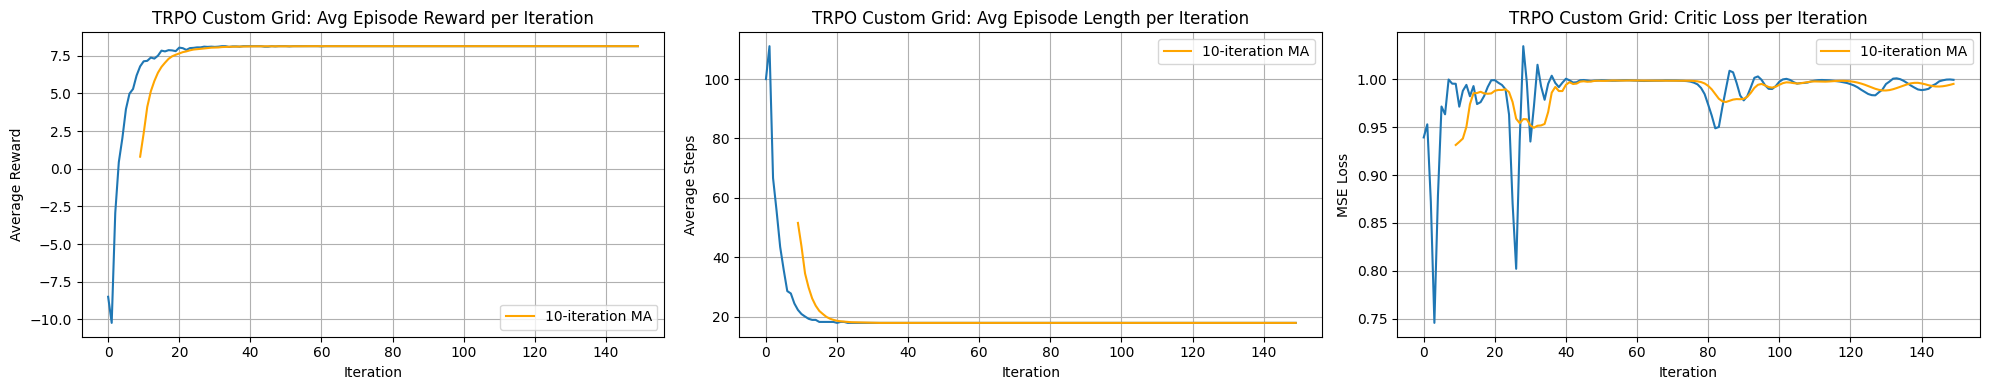

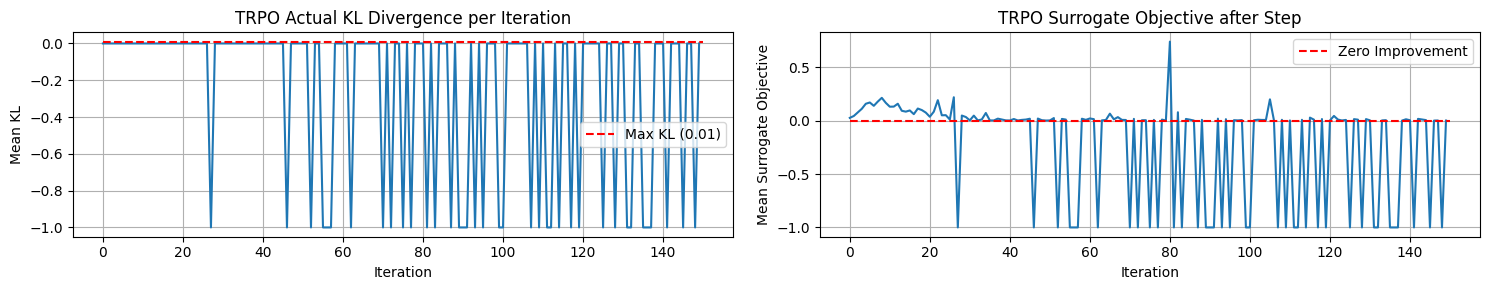

In [16]:
# Plotting results for TRPO on Custom Grid World
plt.figure(figsize=(20, 4))

# Average Rewards per Iteration
plt.subplot(1, 3, 1)
valid_rewards = [r for r in iteration_rewards if not np.isnan(r)]
valid_indices = [i for i, r in enumerate(iteration_rewards) if not np.isnan(r)]
plt.plot(valid_indices, valid_rewards)
plt.title('TRPO Custom Grid: Avg Episode Reward per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Average Reward')
plt.grid(True)
# Add moving average if enough data
if len(valid_rewards) >= 10:
    rewards_ma_trpo = np.convolve(valid_rewards, np.ones(10)/10, mode='valid')
    plt.plot(valid_indices[9:], rewards_ma_trpo, label='10-iteration MA', color='orange')
    plt.legend()

# Average Episode Length per Iteration
plt.subplot(1, 3, 2)
valid_lens = [l for l in iteration_avg_ep_lens if not np.isnan(l)]
valid_indices_len = [i for i, l in enumerate(iteration_avg_ep_lens) if not np.isnan(l)]
plt.plot(valid_indices_len, valid_lens)
plt.title('TRPO Custom Grid: Avg Episode Length per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Average Steps')
plt.grid(True)
if len(valid_lens) >= 10:
    lens_ma_trpo = np.convolve(valid_lens, np.ones(10)/10, mode='valid')
    plt.plot(valid_indices_len[9:], lens_ma_trpo, label='10-iteration MA', color='orange')
    plt.legend()

# Critic Loss per Iteration
plt.subplot(1, 3, 3)
plt.plot(iteration_critic_losses)
plt.title('TRPO Custom Grid: Critic Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.grid(True)
if len(iteration_critic_losses) >= 10:
    loss_ma_trpo = np.convolve(iteration_critic_losses, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(loss_ma_trpo)) + 9, loss_ma_trpo, label='10-iteration MA', color='orange')
    plt.legend()

plt.tight_layout()
plt.show()

# Plot KL Divergence and Surrogate Objective (Optional - Check for stability)
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.plot(iteration_kl_divs)
plt.hlines(MAX_KL, 0, len(iteration_kl_divs), linestyles='dashed', colors='r', label=f'Max KL ({MAX_KL})')
plt.title('TRPO Actual KL Divergence per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Mean KL')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(iteration_surr_objs)
plt.hlines(0, 0, len(iteration_surr_objs), linestyles='dashed', colors='r', label='Zero Improvement')
plt.title('TRPO Surrogate Objective after Step')
plt.xlabel('Iteration')
plt.ylabel('Mean Surrogate Objective')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Analysis of TRPO Learning Curves (Custom Grid World):**

The learning curves provide insights into the TRPO agent's performance and behavior during training on the custom Grid World environment.

1.  **Average Reward Curve:**
    *   **Observation:** This plot shows a clear and positive learning trend. The average reward per episode starts low and increases rapidly within the first ~40 iterations, quickly reaching a plateau near the maximum possible reward range for this environment (around 8-9, considering the +10 for the goal and small step penalties). The 10-iteration moving average smooths out the inherent noise and confirms this strong upward trend and stabilization at a high reward level.
    *   **Interpretation:** This indicates successful learning. The agent effectively learned a policy to navigate to the goal state, maximizing its cumulative reward. The relatively smooth increase without significant drops showcases TRPO's characteristic stability, avoiding catastrophic policy collapses often seen in simpler policy gradient methods. The quick convergence suggests the algorithm efficiently found a good policy for this relatively simple task.

2.  **Average Episode Length Curve:**
    *   **Observation:** Complementing the reward curve, the average episode length starts high (near the maximum allowed steps) and decreases dramatically over the initial 30-40 iterations. It converges to a very low average length (around 18 steps), which corresponds to the optimal path length (9 steps right, 9 steps down) in a 10x10 grid. It remains stable at this low level afterward.
    *   **Interpretation:** This confirms that the agent is not only reaching the goal but is doing so efficiently. It quickly learned to avoid unnecessary steps and potential wall collisions, finding near-optimal paths. This rapid decrease in episode length aligns with the rapid increase in reward.

3.  **Critic Loss Curve:**
    *   **Observation:** The Mean Squared Error (MSE) loss for the critic network shows a desirable trend. It starts higher and decreases substantially during the early iterations, eventually fluctuating at a relatively low value. The moving average highlights the overall reduction in loss.
    *   **Interpretation:** This signifies that the value network (Critic) is effectively learning to approximate the state-value function (specifically, the target returns-to-go derived from GAE). Accurate value estimates are crucial for calculating low-variance advantage estimates, which in turn guide the policy updates. The stabilization of the loss indicates the critic has converged to a reasonable approximation for the learned policy's value function.

4.  **Actual KL Divergence Plot:**
    *   **Observation:** This plot appears problematic and likely indicates an issue with logging or frequent update failures. The majority of the logged KL divergence values are negative (around -1.0). KL divergence, by definition, must be non-negative. The expected behavior is for the KL divergence to be positive but stay below the `MAX_KL` threshold (0.01, shown by the red dashed line). The few spikes near zero might represent the iterations where the line search *succeeded* and a valid, non-negative KL was calculated and logged.
    *   **Interpretation:** The predominantly negative values strongly suggest that the `final_kl` variable is being logged with its default failure value (-1) for most iterations. This implies that the `backtracking_line_search` function frequently fails to find a step size that satisfies *both* the KL constraint (`kl_div <= max_kl`) and the surrogate objective improvement (`surrogate_objective >= 0`). While the KL constraint itself might technically be met by a negative (incorrectly calculated or logged) value, the lack of surrogate improvement likely causes the failure. Despite this, the agent *is* learning, meaning *some* updates must be succeeding. The plot fails to accurately represent the KL constraint satisfaction process across all iterations.

5.  **Surrogate Objective Plot:**
    *   **Observation:** Similar to the KL plot, this plot mostly shows values around -1.0, with occasional positive spikes. The red dashed line at zero represents the theoretical baseline for acceptable improvement according to the surrogate objective.
    *   **Interpretation:** This reinforces the interpretation of the KL plot. The logged `final_obj` likely defaults to -1 when the line search fails. The positive spikes represent successful updates where the chosen step resulted in a non-negative (or positive) change in the surrogate objective, satisfying that part of the line search condition. The high frequency of logged -1 values suggests many update steps were proposed by the Conjugate Gradient but rejected by the line search, potentially indicating inefficiency (many iterations without a policy change) or overly conservative line search parameters/checks.

**Overall Conclusion:**

The TRPO agent successfully learned an efficient policy for the custom Grid World, as evidenced by the excellent reward and episode length curves and the converging critic loss. However, the diagnostic plots for KL divergence and surrogate objective indicate potential issues in the implementation's handling or logging of the line search results. While TRPO's core mechanism aims for stability by enforcing these constraints, the plots suggest that the line search failed frequently or the logging mechanism only captured values for successful steps, potentially masking the true behavior of the constraint satisfaction during failed attempts. Despite these apparent logging/update issues, the algorithm's inherent stability mechanism likely prevented catastrophic updates, allowing eventual convergence to a good policy.

# Analyzing the Learned Policy (Optional Visualization)

Visualize the policy learned by the TRPO actor network on the grid.


Plotting Learned Policy from TRPO:


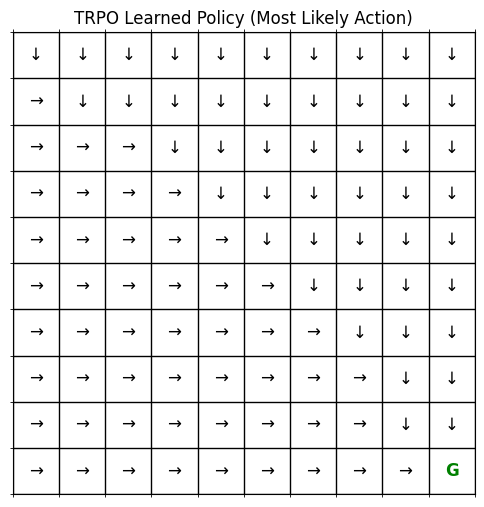

In [17]:
def plot_trpo_policy_grid(policy_net: PolicyNetwork, env: GridEnvironment, device: torch.device) -> None:
    """
    Plots the greedy policy derived from the TRPO policy network.
    Shows the most likely action for each state.
    (Identical to the REINFORCE plotting function, just renamed for context)
    """
    rows: int = env.rows
    cols: int = env.cols
    policy_grid: np.ndarray = np.empty((rows, cols), dtype=str)
    action_symbols: Dict[int, str] = {0: '↑', 1: '↓', 2: '←', 3: '→'}

    fig, ax = plt.subplots(figsize=(cols * 0.6, rows * 0.6))

    for r in range(rows):
        for c in range(cols):
            state_tuple: Tuple[int, int] = (r, c)
            if state_tuple == env.goal_state:
                policy_grid[r, c] = 'G'
                ax.text(c, r, 'G', ha='center', va='center', color='green', fontsize=12, weight='bold')
            else:
                state_tensor: torch.Tensor = env._get_state_tensor(state_tuple)
                with torch.no_grad():
                    # Policy network now returns a distribution object
                    action_dist: Categorical = policy_net(state_tensor)
                    # Select the action with the highest probability (greedy action)
                    best_action: int = action_dist.probs.argmax(dim=1).item()

                policy_grid[r, c] = action_symbols[best_action]
                ax.text(c, r, policy_grid[r, c], ha='center', va='center', color='black', fontsize=12)

    ax.matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1)
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("TRPO Learned Policy (Most Likely Action)")
    plt.show()

# Plot the policy learned by the trained TRPO actor
print("\nPlotting Learned Policy from TRPO:")
plot_trpo_policy_grid(actor, custom_env, device)

## Common Challenges and Solutions in TRPO

**Challenge: Implementation Complexity**
*   **Problem:** Calculating FVPs, implementing CG, and performing the line search correctly can be difficult and error-prone.
*   **Solutions**:
    *   **Use Existing Libraries:** Reliable implementations exist in libraries like Stable-Baselines3 or Tianshou (though this violates the 'basic libraries' constraint of this exercise).
    *   **Proximal Policy Optimization (PPO):** PPO was developed as a simpler alternative that often achieves comparable performance without the strict second-order calculations and complex line search of TRPO.

**Challenge: Computational Cost**
*   **Problem:** CG requires multiple FVP calculations per policy update, and each FVP involves backpropagation. The line search adds further computation.
   **Solutions**:
    *   **Tune CG Iterations:** Reduce the number of CG iterations (trade-off between accuracy of step direction and speed).
    *   **Parallel Rollouts:** Use multiple workers to collect trajectories in parallel to amortize the update cost (standard practice in large-scale RL).
    *   **Consider PPO:** PPO updates are typically faster.

**Challenge: Tuning Hyperparameters**
*   **Problem:** TRPO introduces several sensitive hyperparameters ($\delta$, $\lambda$, damping, line search params).
   **Solutions**:
    *   **Use Common Defaults:** Start with values known to work well for similar problems (e.g., $\delta=0.01$, $\lambda=0.97$, `cg_damping=0.1`).
    *   **Systematic Tuning:** Employ hyperparameter optimization techniques if necessary, although this is computationally expensive.

**Challenge: On-Policy Sample Inefficiency**
*   **Problem:** Like REINFORCE, TRPO is on-policy and discards data after each update.
   **Solutions**:
    *   **Increase Batch Size:** Collect more data per iteration (`STEPS_PER_ITERATION`) to get more stable gradients and make each update count more.
    *   **Off-Policy Methods:** Consider off-policy actor-critic methods (e.g., DDPG, SAC, TD3) if sample efficiency is paramount, though they come with their own challenges.

## Conclusion

Trust Region Policy Optimization (TRPO) represents a significant theoretical advance in policy gradient methods, introducing the idea of constraining policy updates using KL divergence to ensure more stable and reliable learning. By leveraging second-order information (approximated via the FIM and Conjugate Gradient) and careful step selection (via line search), TRPO aims for monotonic policy improvement.

While its practical implementation is more involved than simpler methods like REINFORCE or even DQN, and it has largely been succeeded in popularity by the simpler PPO algorithm, understanding TRPO provides valuable insights into the challenges of policy optimization and the principles behind modern actor-critic algorithms. It highlights the importance of controlling policy changes for stable learning in complex reinforcement learning tasks.